In [1]:
#importing required Libraries
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
#!pip install gym
#!pip install 'stable-baselines3[extra]'
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym

In [2]:
# Defining the file path
file_path = 'sampled_dataset.csv'  

# Loading dataset
sampled_data = pd.read_csv(file_path)

# Displaying information about the dataset 
print(sampled_data.info())

# Displaying the first few rows of the dataset
print(sampled_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12004 entries, 0 to 12003
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       12004 non-null  int64  
 1   X           12004 non-null  float64
 2   Y           12004 non-null  float64
 3   FID         12004 non-null  int64  
 4   FEATURE_ID  12004 non-null  int64  
 5   NAME        12004 non-null  object 
 6   ADDRESS     12004 non-null  object 
 7   ADDRESS2    12004 non-null  object 
 8   ADDRESS3    12004 non-null  object 
 9   CITY        12004 non-null  object 
 10  STATE       12004 non-null  object 
 11  ZIP         12004 non-null  int64  
 12  PHONE       12004 non-null  object 
 13  LATITUDE    12004 non-null  float64
 14  LONGITUDE   12004 non-null  float64
 15  MATCHSTATU  12004 non-null  object 
 16  PLACEMENT   12004 non-null  object 
 17  CENSUSCODE  12004 non-null  object 
 18  BUSINESSNA  12004 non-null  object 
dtypes: float64(4), int64(4), 

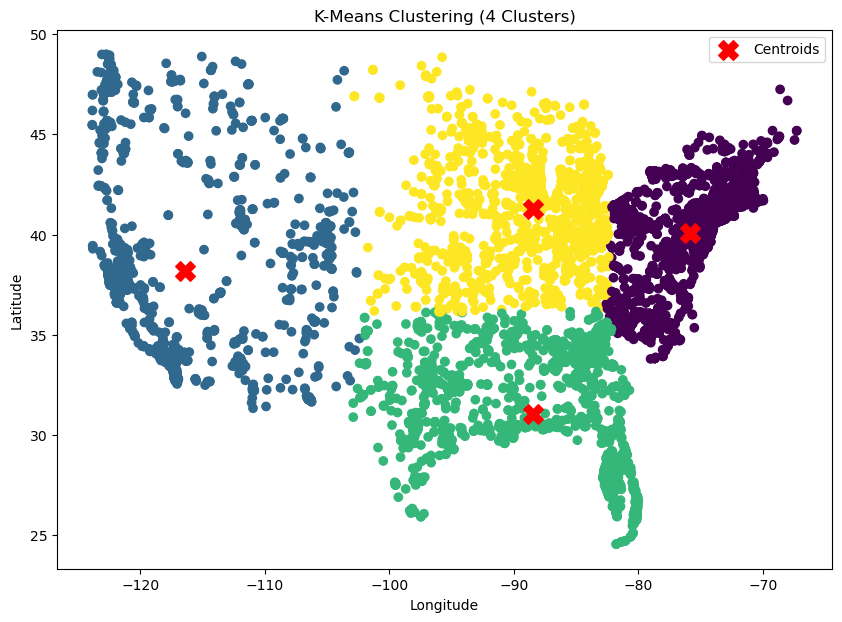

Number of points in each cluster:
Cluster
0    3805
3    2993
2    2907
1    2299
Name: count, dtype: int64


In [3]:
# Selecting the features for clustering
X = sampled_data[['LATITUDE', 'LONGITUDE']]

# Applying K-Means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
sampled_data['Cluster'] = kmeans.fit_predict(X)

# Centroids of the clusters
centroids = kmeans.cluster_centers_

# Visualize
plt.figure(figsize=(10, 7))
plt.scatter(sampled_data['LONGITUDE'], sampled_data['LATITUDE'], c=sampled_data['Cluster'], cmap='viridis', marker='o')
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', marker='X', s=200, label='Centroids')
plt.title('K-Means Clustering (4 Clusters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Displaying the number of points in each cluster
cluster_counts = sampled_data['Cluster'].value_counts()
print("Number of points in each cluster:")
print(cluster_counts)

In [4]:
# function to safely normalize a row for probability calculation
def safe_normalize(row):
    total = np.sum(row)
    if total > 0:
        return row / total
    else:
        return np.zeros_like(row)

# Iterating over each cluster and applying ACO
for cluster_id in sampled_data['Cluster'].unique():
    # Select data for the current cluster
    cluster_data = sampled_data[sampled_data['Cluster'] == cluster_id]

    # Identifying the warehouse and drop boxes within the cluster
    warehouse = cluster_data[cluster_data['NAME'] == 'Authorized Shipping Outlet'].iloc[0]
    drop_boxes = cluster_data[cluster_data['NAME'] == 'UPS Drop Box']

    # Combining warehouse and drop boxes for the distance matrix calculation
    locations = pd.concat([warehouse.to_frame().T, drop_boxes])

    # Calculating the distance matrix
    coords = locations[['LATITUDE', 'LONGITUDE']].values
    dist_matrix = distance_matrix(coords, coords)

    # Ensuring all distances are non-zero by replacing small values with a minimum threshold
    dist_matrix[dist_matrix < 1e-10] = 1e-10

    # Applying ACO 
    n_ants = 10
    n_best = 3
    n_iterations = 100
    decay = 0.95

    class ACO:
        def __init__(self, dist_matrix, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
            self.dist_matrix = dist_matrix
            self.pheromone = np.ones(self.dist_matrix.shape) / len(dist_matrix)
            self.all_inds = range(len(dist_matrix))
            self.n_ants = n_ants
            self.n_best = n_best
            self.n_iterations = n_iterations
            self.decay = decay
            self.alpha = alpha
            self.beta = beta

        def run(self):
            shortest_path = None
            all_time_shortest_path = ("placeholder", np.inf)
            for i in range(self.n_iterations):
                all_paths = self.construct_colony_paths()
                self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
                shortest_path = min(all_paths, key=lambda x: x[1])
                if shortest_path[1] < all_time_shortest_path[1]:
                    all_time_shortest_path = shortest_path            
                self.pheromone *= self.decay            
            return all_time_shortest_path

        def spread_pheronome(self, all_paths, n_best, shortest_path):
            sorted_paths = sorted(all_paths, key=lambda x: x[1])
            for path, dist in sorted_paths[:n_best]:
                for move in path:
                    self.pheromone[move] += 1.0 / self.dist_matrix[move]

        def construct_colony_paths(self):
            all_paths = []
            for i in range(self.n_ants):
                path = self.construct_path(0)
                all_paths.append((path, self.calculate_path_distance(path)))
            return all_paths

        def construct_path(self, start):
            path = []
            visited = set()
            visited.add(start)
            prev = start
            for _ in range(len(self.dist_matrix) - 1):
                move = self.pick_move(self.pheromone[prev], self.dist_matrix[prev], visited)
                path.append((prev, move))
                prev = move
                visited.add(move)
            path.append((prev, start))  # Returning to starting point
            return path

        def pick_move(self, pheromone, dist, visited):
            pheromone = np.copy(pheromone)
            pheromone[list(visited)] = 0
            with np.errstate(divide='ignore', invalid='ignore'):
                row = pheromone ** self.alpha * ((1.0 / dist) ** self.beta)
                row = safe_normalize(row)  # Ensure the row is normalized and valid
            move = np.random.choice(self.all_inds, 1, p=row)[0]
            return move

        def calculate_path_distance(self, path):
            total_dist = 0
            for ele in path:
                total_dist += self.dist_matrix[ele]
            return total_dist

    try:
        aco = ACO(dist_matrix, n_ants, n_best, n_iterations, decay, alpha=1, beta=2)
        shortest_path = aco.run()

        print(f"Cluster {cluster_id}: Shortest path: {shortest_path[0]}")
        print(f"Cluster {cluster_id}: Shortest path distance: {shortest_path[1]} km")
    except ValueError as e:
        print(f"Error in cluster {cluster_id}: {e}")

Cluster 0: Shortest path: [(0, 2480), (2480, 63), (63, 1246), (1246, 3052), (3052, 141), (141, 3465), (3465, 3475), (3475, 2207), (2207, 2896), (2896, 1275), (1275, 2147), (2147, 2934), (2934, 3132), (3132, 1590), (1590, 2478), (2478, 2674), (2674, 120), (120, 3021), (3021, 3317), (3317, 1389), (1389, 2717), (2717, 1374), (1374, 516), (516, 688), (688, 3117), (3117, 1635), (1635, 2894), (2894, 2343), (2343, 2106), (2106, 1131), (1131, 1116), (1116, 3184), (3184, 693), (693, 1648), (1648, 2812), (2812, 1221), (1221, 265), (265, 3121), (3121, 939), (939, 30), (30, 2085), (2085, 1307), (1307, 2203), (2203, 1153), (1153, 3054), (3054, 2400), (2400, 165), (165, 24), (24, 1936), (1936, 2220), (2220, 1945), (1945, 1295), (1295, 1054), (1054, 1491), (1491, 2526), (2526, 973), (973, 3070), (3070, 368), (368, 447), (447, 1824), (1824, 2767), (2767, 2127), (2127, 1521), (1521, 3436), (3436, 3029), (3029, 3305), (3305, 2399), (2399, 234), (234, 522), (522, 1301), (1301, 123), (123, 2808), (2808, 1

In [5]:
#Applying DRL on ACO routes
class TSPEnv(gym.Env):
    def __init__(self, distance_matrix, initial_route, render_mode=None):
        super(TSPEnv, self).__init__()
        self.distance_matrix = distance_matrix
        self.num_locations = len(distance_matrix)
        self.start_location = initial_route[0]  # Starting point (warehouse)
        self.end_location = initial_route[-1]   # Ending point (drop box)
        self.visited = [self.start_location]  # Start with the warehouse index only
        self.current_location = self.start_location
        self.render_mode = render_mode  # Add render_mode

        # Define action and observation space
        self.action_space = gym.spaces.Discrete(self.num_locations)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.num_locations,), dtype=np.int32)
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Handles seeding if needed
        self.visited = [self.start_location]  # Reset to start from the warehouse
        self.current_location = self.start_location
        return self._get_observation(), {}

    def _get_observation(self):
        obs = np.zeros(self.num_locations, dtype=np.int32)
        for loc in self.visited:
            obs[loc] = 1
        return obs

    def step(self, action):
        action = int(action)
        if action in self.visited:
            reward = -200  # Increase penalty for revisiting locations
        else:
            self.visited.append(action)
            reward = -self.distance_matrix[self.current_location, action]
            self.current_location = action

        done = (len(self.visited) == self.num_locations and 
                self.current_location == self.end_location)
        
        if done:
            reward += 2000  

        obs = self._get_observation()
        info = {}
        return obs, reward, done, False, info  # Return False for truncated

    def render(self):
        if self.render_mode == 'human':
            pass  # Implement any visualization logic here if needed

# Processing each cluster
for cluster_id in sampled_data['Cluster'].unique():
    cluster_data = sampled_data[sampled_data['Cluster'] == cluster_id]
    
    initial_route = shortest_path  # Contains both the path and distance
    initial_route_indices = [pair[0] for pair in initial_route[0]]
    
    coordinates = cluster_data[['LATITUDE', 'LONGITUDE']].values
    dist_matrix = distance_matrix(coordinates, coordinates)
    
    env = DummyVecEnv([lambda: TSPEnv(dist_matrix, initial_route_indices, render_mode='human')])
    
    model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-4, n_steps=2048, gamma=0.99)
    model.learn(total_timesteps=100000)  # Increase timesteps
    
    obs = env.reset()
    for _ in range(100):  
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        env.render()
    
    refined_route = env.envs[0].visited
    refined_distance = np.sum([dist_matrix[refined_route[i], refined_route[i+1]] for i in range(len(refined_route) - 1)])
    
    print(f"Cluster {cluster_id}: Shortest path distance using ACO + DRL: {refined_distance:.2f} km")
    print(f"Cluster {cluster_id}: Refined route order of locations: {refined_route}")

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2959 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1269          |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 2.6198395e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -8.24         |
|    explained_variance   | 0.000384      |
|    learning_rate        | 0.0001        |
|    loss                 | 4.48e+05      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000898     |
|    value_loss           | 8.54e+05      |
-------------------------

In [6]:
# Estimating Co2 emissions for ACO-DRl
# Define constants
fuel_consumption_per_km = 0.12  # in liters per km
co2_emissions_factor = 2.31  # kg CO2 per liter of petrol

# Cluster distances
cluster_distances = [396.25, 872.58, 819.87, 580.15]

# Calculate CO2 emissions for each cluster
co2_emissions = [distance * fuel_consumption_per_km * co2_emissions_factor for distance in cluster_distances]

# Display CO2 emissions for each cluster
for i, emissions in enumerate(co2_emissions):
    print(f"Cluster {i}: Estimated CO2 Emissions: {emissions:.2f} kg")

# Sum distances for a single total distance
total_distance = sum(cluster_distances)

# Sum CO2 emissions for a single total value
total_co2_emissions = sum(co2_emissions)

print(f"Total Distance: {total_distance:.2f} km")
print(f"Total CO2 Emissions: {total_co2_emissions:.2f} kg")

Cluster 0: Estimated CO2 Emissions: 109.84 kg
Cluster 1: Estimated CO2 Emissions: 241.88 kg
Cluster 2: Estimated CO2 Emissions: 227.27 kg
Cluster 3: Estimated CO2 Emissions: 160.82 kg
Total Distance: 2668.85 km
Total CO2 Emissions: 739.81 kg


In [7]:
# Estimating Co2 emissions for ACO
# Define constants
fuel_consumption_per_km = 0.12  # in liters per km
co2_emissions_factor = 2.31  # kg CO2 per liter of petrol

# Cluster distances
cluster_distances = [442.68, 431.08, 481.29, 564.87]

# Calculate CO2 emissions for each cluster
co2_emissions = [distance * fuel_consumption_per_km * co2_emissions_factor for distance in cluster_distances]

# Display CO2 emissions for each cluster
for i, emissions in enumerate(co2_emissions):
    print(f"Cluster {i}: Estimated CO2 Emissions for ACO: {emissions:.2f} kg")

# Sum distances for a single total distance
total_distance = sum(cluster_distances)

# Sum CO2 emissions for a single total value
total_co2_emissions = sum(co2_emissions)

print(f"Total Distance: {total_distance :.2f} km")
print(f"Total CO2 Emissions: {total_co2_emissions :.2f} kg")

Cluster 0: Estimated CO2 Emissions for ACO: 122.71 kg
Cluster 1: Estimated CO2 Emissions for ACO: 119.50 kg
Cluster 2: Estimated CO2 Emissions for ACO: 133.41 kg
Cluster 3: Estimated CO2 Emissions for ACO: 156.58 kg
Total Distance: 1919.92 km
Total CO2 Emissions: 532.20 kg


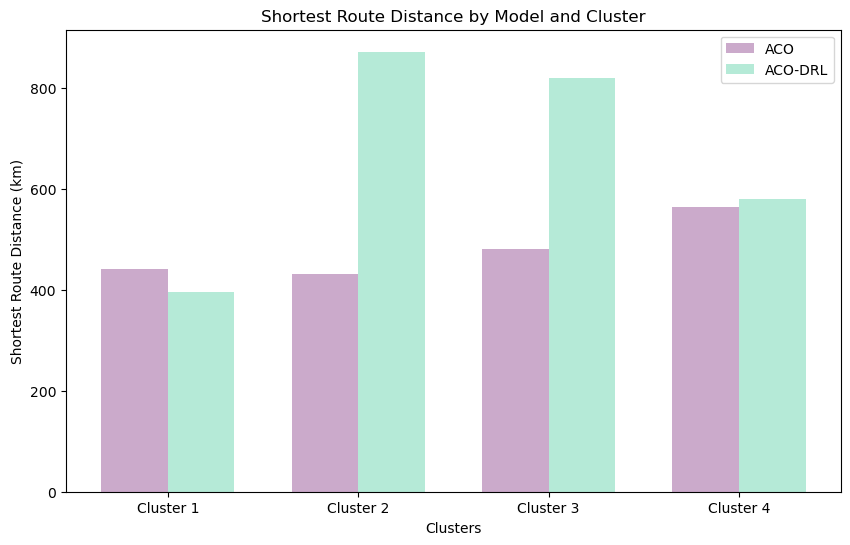

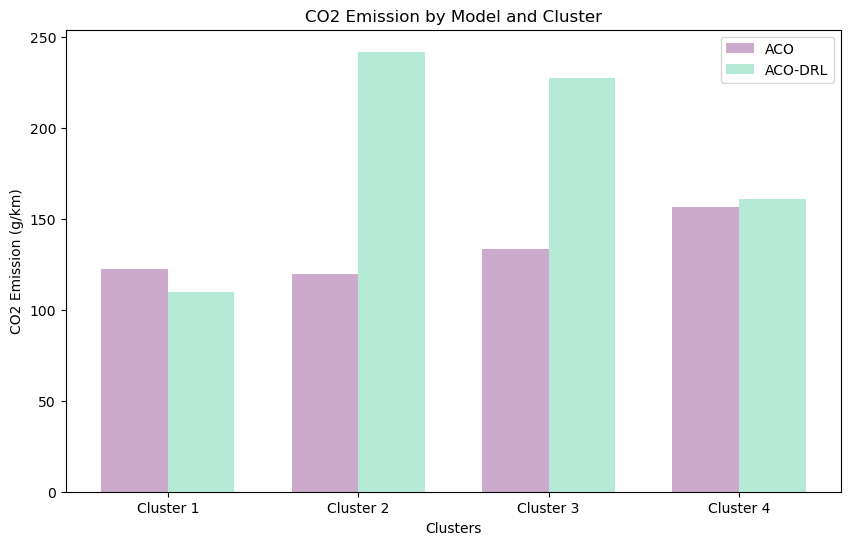

In [8]:
# Saving cluster distances and Co2 emissions
clusters = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
aco_shortest_route = [442.68, 431.08, 481.29, 564.87]
aco_drl_shortest_route = [396.25, 872.58, 819.87, 580.15]
 
aco_co2_emission = [122.71, 119.49, 133.41, 156.58]
aco_drl_co2_emission = [109.84, 241.88, 227.27, 160.82]
 

pastel_colors = {
    'aco': '#CBAACB',  
    'aco_drl': '#B5EAD7'  
}
 
# Bar Chart for Shortest Route Distance
x = np.arange(len(clusters))
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, aco_shortest_route, width, label='ACO', color=pastel_colors['aco'])
rects2 = ax.bar(x + width/2, aco_drl_shortest_route, width, label='ACO-DRL', color=pastel_colors['aco_drl'])

ax.set_xlabel('Clusters')
ax.set_ylabel('Shortest Route Distance (km)')
ax.set_title('Shortest Route Distance by Model and Cluster')
ax.set_xticks(x)
ax.set_xticklabels(clusters)
ax.legend()


plt.show()

# Bar Chart for CO2 Emissions
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, aco_co2_emission, width, label='ACO', color=pastel_colors['aco'])
rects2 = ax.bar(x + width/2, aco_drl_co2_emission, width, label='ACO-DRL', color=pastel_colors['aco_drl'])

ax.set_xlabel('Clusters')
ax.set_ylabel('CO2 Emission (g/km)')
ax.set_title('CO2 Emission by Model and Cluster')
ax.set_xticks(x)
ax.set_xticklabels(clusters)
ax.legend()

plt.show()